In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import requests
from xml.etree import ElementTree as ET
import statsmodels.api as sm
import statsmodels
from sklearn.preprocessing import StandardScaler
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller

In [90]:
## CNH 데이터 입력
CNH_df = pd.read_csv('C:/Muzin/Fixers_C/USD_CNH 과거 데이터.csv')

# CNH 시간, 종가, 시가, 고가, 저가 분리
CNH_df_Time = CNH_df.iloc[:, 0]
CNH_df_Ed = CNH_df.iloc[:, 1]
CNH_df_St = CNH_df.iloc[:, 2]
CNH_df_Hi = CNH_df.iloc[:, 3]
CNH_df_Lw = CNH_df.iloc[:, 4]
CNH_data=[CNH_df_Ed, CNH_df_St, CNH_df_Hi, CNH_df_Lw]

## DTW 분석 데이터 입력
DTW_df = pd.read_csv('C:/Muzin/Fixers_C/PCA용 가상 데이터.csv')
DTW_df_Time = DTW_df.iloc[:,0]
DTW_df.drop(DTW_df.columns[0], axis=1, inplace = True)

In [91]:
# 데이터 점검용 콘솔
print(DTW_df)
print(CNH_df_Ed)

       101     102     103     104
0   7.3352  7.3239  7.3432  7.3039
1   7.3027  7.3351  7.3501  7.2969
2   7.3068  7.3028  7.3192  7.2822
3   7.2872  7.3075  7.3366  7.2780
4   7.3044  7.2883  7.3170  7.2685
5   7.2856  7.3064  7.3081  7.2823
6   7.2802  7.2868  7.2952  7.2675
7   7.2939  7.2808  7.3021  7.2797
8   7.2929  7.2940  7.3060  7.2694
9   7.2832  7.2931  7.3112  7.2798
10  7.3022  7.2832  7.3054  7.2806
11  7.2746  7.3033  7.3038  7.2682
12  7.2669  7.2761  7.2783  7.2387
13  7.2753  7.2677  7.2793  7.2544
14  7.3042  7.2754  7.3122  7.2739
15  7.3195  7.3042  7.3284  7.3012
16  7.3409  7.3204  7.3459  7.3184
17  7.3650  7.3423  7.3684  7.3341
18  7.3015  7.3657  7.3660  7.2915
19  7.3007  7.3025  7.3149  7.2923
20  7.2709  7.3015  7.3064  7.2688
21  7.2890  7.2719  7.2975  7.2605
22  7.2796  7.2901  7.2959  7.2592
23  7.2901  7.2810  7.2991  7.2718
24  7.3036  7.2917  7.3081  7.2882
25  7.3059  7.3036  7.3162  7.2879
26  7.3142  7.3072  7.3219  7.3032
27  7.2987  7.3142  

In [92]:
## 목표 데이터(CNH)와 DTW 데이터 결합
CNH_df_Ed_com = pd.concat([CNH_df_Ed, DTW_df], axis=1)
CNH_df_St_com = pd.concat([CNH_df_St, DTW_df], axis=1)
CNH_df_Hi_com = pd.concat([CNH_df_Hi, DTW_df], axis=1)
CNH_df_Lw_com = pd.concat([CNH_df_Lw, DTW_df], axis=1)

In [93]:
### 이하 자료는 CNH_df_Ed_com에 대한 분석치
## 데이터프레임 점검
print(CNH_df_Lw_com)

        저가     101     102     103     104
0   7.3039  7.3352  7.3239  7.3432  7.3039
1   7.2969  7.3027  7.3351  7.3501  7.2969
2   7.2822  7.3068  7.3028  7.3192  7.2822
3   7.2780  7.2872  7.3075  7.3366  7.2780
4   7.2685  7.3044  7.2883  7.3170  7.2685
5   7.2823  7.2856  7.3064  7.3081  7.2823
6   7.2675  7.2802  7.2868  7.2952  7.2675
7   7.2797  7.2939  7.2808  7.3021  7.2797
8   7.2694  7.2929  7.2940  7.3060  7.2694
9   7.2798  7.2832  7.2931  7.3112  7.2798
10  7.2806  7.3022  7.2832  7.3054  7.2806
11  7.2682  7.2746  7.3033  7.3038  7.2682
12  7.2387  7.2669  7.2761  7.2783  7.2387
13  7.2544  7.2753  7.2677  7.2793  7.2544
14  7.2739  7.3042  7.2754  7.3122  7.2739
15  7.3012  7.3195  7.3042  7.3284  7.3012
16  7.3184  7.3409  7.3204  7.3459  7.3184
17  7.3341  7.3650  7.3423  7.3684  7.3341
18  7.2915  7.3015  7.3657  7.3660  7.2915
19  7.2923  7.3007  7.3025  7.3149  7.2923
20  7.2688  7.2709  7.3015  7.3064  7.2688
21  7.2605  7.2890  7.2719  7.2975  7.2605
22  7.2592 

In [94]:
## 다중공선성 확인 및 데이터 점검
X = CNH_df_Ed_com.iloc[:,1:]
y = CNH_df_Ed_com.iloc[:,0]

vif = [variance_inflation_factor(X.values, i)for i in range(X.shape[1])]

result = sm.OLS(y,X).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                     종가   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.541e+29
Date:                Sun, 05 Nov 2023   Prob (F-statistic):                        0.00
Time:                        17:06:27   Log-Likelihood:                          1661.8
No. Observations:                  57   AIC:                                     -3316.
Df Residuals:                      53   BIC:                                     -3307.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [95]:
## n_components 수 변경하면서 PCA 수행
pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['p1',
                                                                 'p2'])
principalDf.head()

,p1,p2
0,0.037369,-0.003807
1,0.026217,0.028298
2,-0.010100,-0.000821
3,-0.011473,0.020970
4,-0.026763,-0.006004


In [96]:
## 설명력 확인
pca.explained_variance_ratio_

array([0.85682064, 0.10243481])

In [97]:
#총계 확인
sum(pca.explained_variance_ratio_)

0.9592554454951451

In [98]:
principalDf.index = CNH_df_Time
principalDf

,p1,p2
날짜,,
2023-08-16,0.037369,-0.003807
2023-08-17,0.026217,0.028298
2023-08-18,-0.010100,-0.000821
2023-08-21,-0.011473,0.020970
2023-08-22,-0.026763,-0.006004
2023-08-23,-0.024099,0.012007
2023-08-24,-0.050423,0.002594
2023-08-25,-0.036637,-0.011336
2023-08-28,-0.034471,0.001791


In [111]:
## 데이터 정리
# 주성분 분리
pc1 = np.array(principalDf['p1'])
pc2 = np.array(principalDf['p2'])

# 행 인덱싱
CNH_df_Ed.rename(index=CNH_df_Time.to_dict(), inplace=True)
CNH_df_St.rename(index=CNH_df_Time.to_dict(), inplace=True)
CNH_df_Hi.rename(index=CNH_df_Time.to_dict(), inplace=True)
CNH_df_Lw.rename(index=CNH_df_Time.to_dict(), inplace=True)

# 원본 데이터 재지정
y = CNH_df_Ed

In [112]:
## 주성분 분석 데이터와 타겟 데이터 병합
principalDf.index = CNH_df_Time
df = pd.merge(y, principalDf,left_index=True, right_index=True,how='inner')
df

,종가,p1,p2
2023-08-16,7.3352,0.037369,-0.003807
2023-08-17,7.3027,0.026217,0.028298
2023-08-18,7.3068,-0.010100,-0.000821
2023-08-21,7.2872,-0.011473,0.020970
2023-08-22,7.3044,-0.026763,-0.006004
2023-08-23,7.2856,-0.024099,0.012007
2023-08-24,7.2802,-0.050423,0.002594
2023-08-25,7.2939,-0.036637,-0.011336
2023-08-28,7.2929,-0.034471,0.001791
2023-08-29,7.2832,-0.031580,0.006277


In [113]:
## 정상성 확인
# 컬럼별로 정상성확인하는 함수
for i in df.columns:
    adfuller_test = adfuller(df[i],autolag='AIC')
    print(i)
    print("ADF test statistic: {}".format(adfuller_test[0]))
    print("p-value: {}".format(adfuller_test[1]))

종가
ADF test statistic: -1.069004194665059
p-value: 0.7272731089851876
p1
ADF test statistic: -3.98745779507297
p-value: 0.00147762875138375
p2
ADF test statistic: -3.386506412916046
p-value: 0.011427558549076849


In [114]:
# 차분 구하기
df_diff = df.diff().dropna()

# 차분 후 정상성 재확인
for i in df.columns:
    adfuller_test = adfuller(df_diff[i],autolag='AIC')
    print(i)
    print("ADF test statistic: {}".format(adfuller_test[0]))
    print("p-value: {}".format(adfuller_test[1]))

종가
ADF test statistic: -3.9955223459710756
p-value: 0.0014341399029839691
p1
ADF test statistic: -3.483452540053851
p-value: 0.008422377840606165
p2
ADF test statistic: -4.786210540275699
p-value: 5.778737778949574e-05


<Axes: >

C:\Users\JeongheeLee\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  func(*args, **kwargs)
C:\Users\JeongheeLee\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  func(*args, **kwargs)
C:\Users\JeongheeLee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\JeongheeLee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


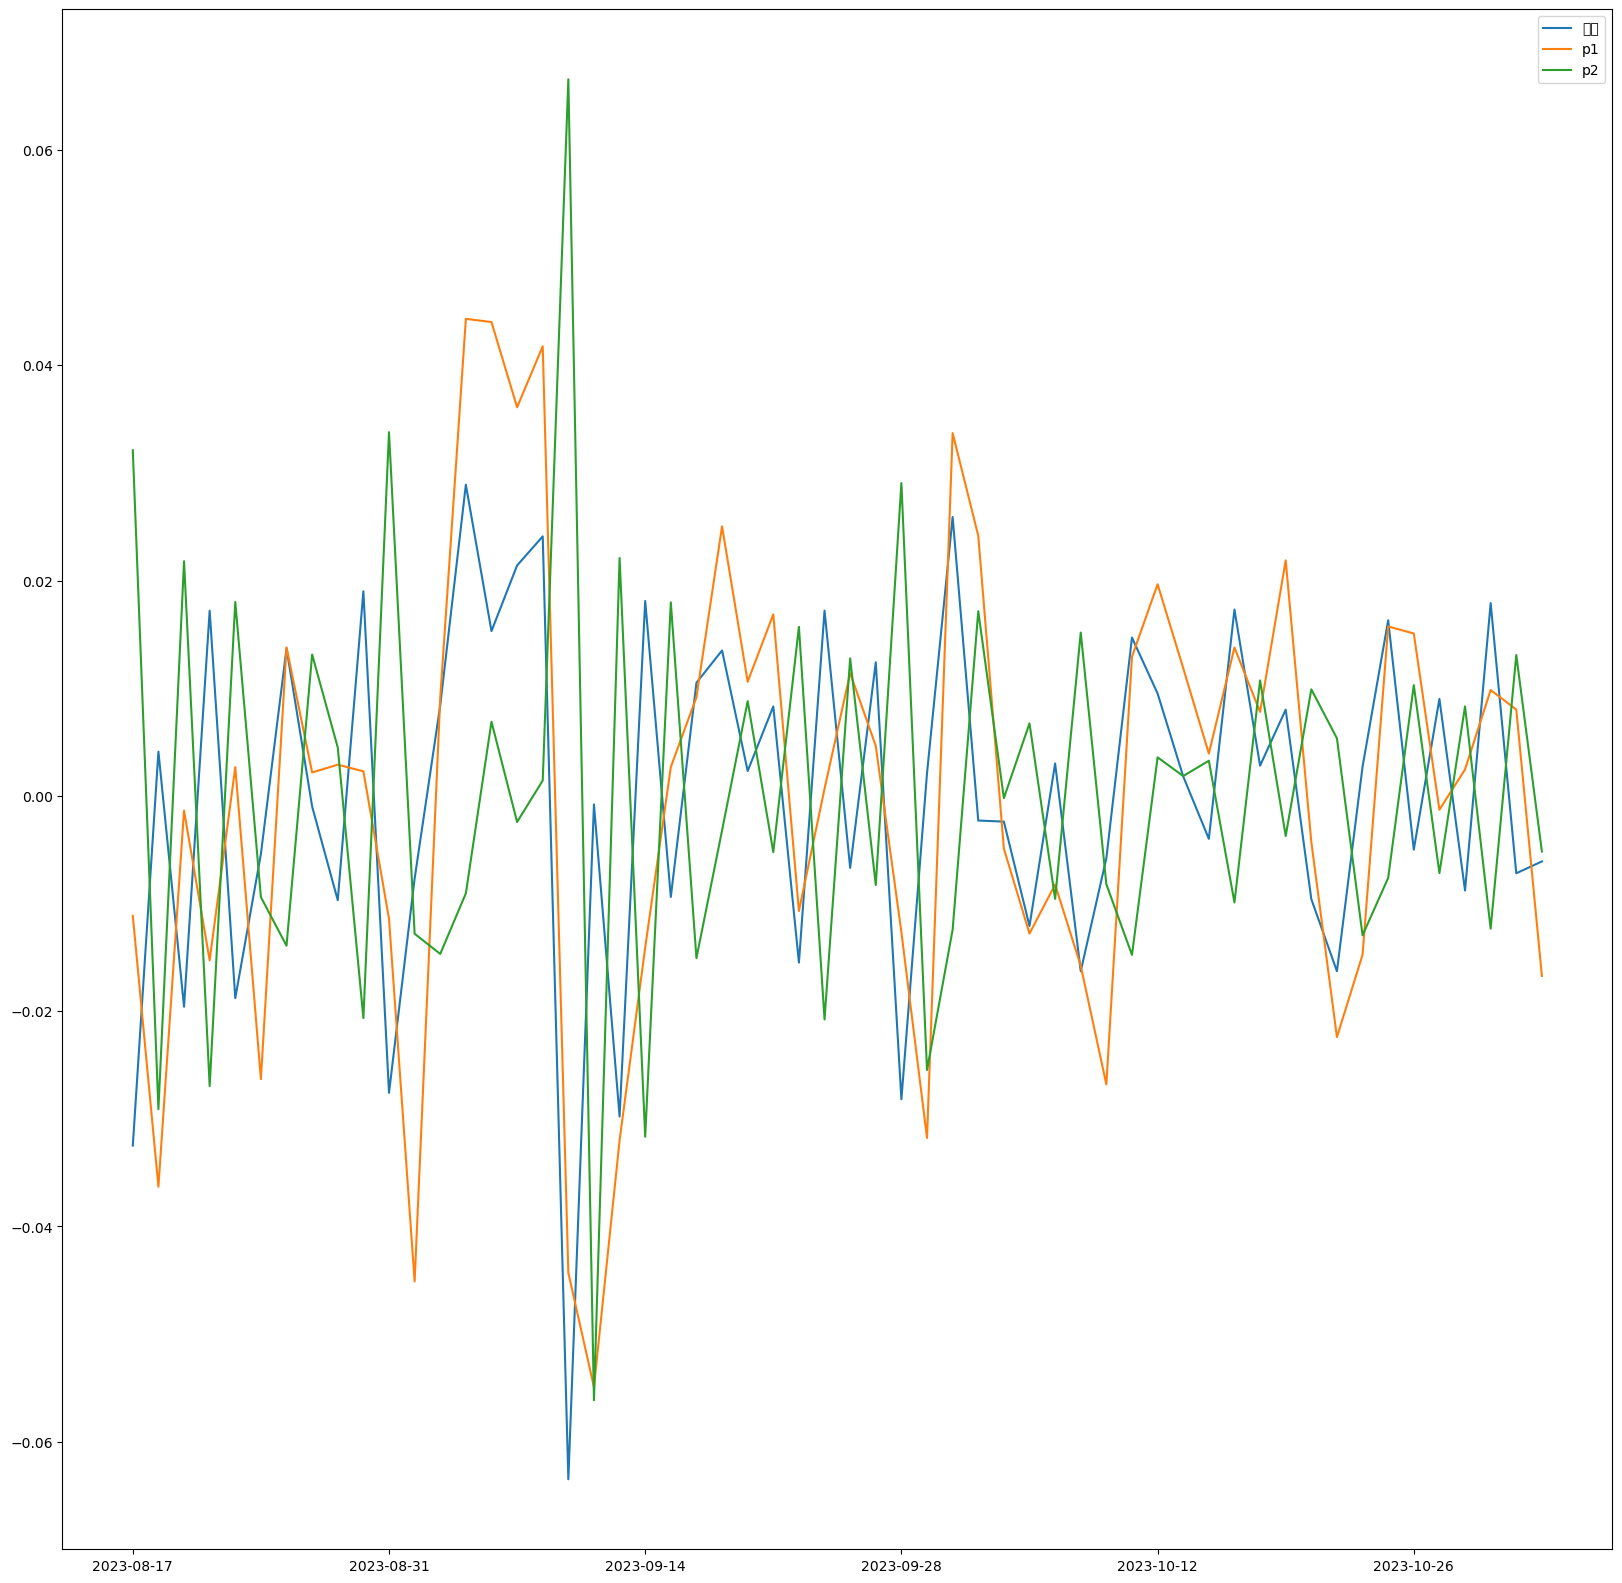

In [115]:
# CNH, p1, p2 플롯 그리기
df_diff.plot(figsize=(20,20))